# **ResNet50 - Post GAN**

In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers as L
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# DataLoader
train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/adversarial-gtsrb-data/Adversarial-GTSRB-Data',
    batch_size=128,
    image_size=(32, 32),
    label_mode="categorical",
    labels = "inferred",
    validation_split=0.2,
    subset='training',
    seed=42,
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/adversarial-gtsrb-data/Adversarial-GTSRB-Data',
    batch_size=128,
    label_mode="categorical",
    labels = "inferred",
    image_size=(32, 32),
    validation_split=0.2,
    subset='validation',
    seed=42,
)

Found 211209 files belonging to 43 classes.
Using 168968 files for training.
Found 211209 files belonging to 43 classes.
Using 42241 files for validation.


In [3]:
train_data.as_numpy_iterator().__next__()[0].shape

(128, 32, 32, 3)

In [4]:
train_data.as_numpy_iterator().__next__()[1].shape

(128, 43)

In [5]:
# Create custom F1 Score Metrics

from keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [6]:
steps_per_epoch = len(train_data)
EPOCHS = 128

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=0.000001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=8,# if val loss decreases for 8 epochs in a row, stop training
                                                  restore_best_weights = True)

In [7]:
# Model

def create_model(shape=(32, 32, 3)):
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top = False,
        input_shape = shape,
        weights = "imagenet",
    )
    
    base_model.trainable = False
    for layer in base_model.layers[-7:]:
#         print(layer)
        layer.trainable = True
        
    x = base_model.output
    x = L.Flatten(name="flatten")(x)
    x = L.Dense(512, activation="relu", name="Dense-1")(x)
    x = L.Dropout(0.4, name="Final-Dropout")(x)
    x = L.Dense(43, activation="softmax", name="Output-layer")(x)
    
    model = tf.keras.models.Model(base_model.input, x, name="EfficientNetB0")
    model.compile(
        loss="categorical_crossentropy",
        optimizer="Adam",
        metrics = ["accuracy",tf.keras.metrics.AUC(name="auc"),
                               tf.keras.metrics.Recall(name="recall"),
                               tf.keras.metrics.Precision(name="precision"),
                              f1_score]
    )
    
    return model

In [8]:
model = create_model()

# Fit the model
history = model.fit(
    train_data,
    epochs = EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_data,
    validation_steps = len(val_data),
    callbacks = [reduce_lr, early_stopping],
)

16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/128


2023-12-10 15:57:41.079726: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetB0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1321/1321 [==============================] - 238s 169ms/step - loss: 1.2263 - accuracy: 0.6320 - auc: 0.9720 - recall: 0.5207 - precision: 0.8126 - f1_score: 0.6235 - val_loss: 0.8080 - val_accuracy: 0.7461 - val_auc: 0.9866 - val_recall: 0.6654 - val_precision: 0.8560 - val_f1_score: 0.7491 - lr: 0.0010
Epoch 2/128
1321/1321 [==============================] - 50s 38ms/step - loss: 0.7727 - accuracy: 0.7573 - auc: 0.9868 - recall: 0.6879 - precision: 0.8561 - f1_score: 0.7623 - val_loss: 0.5681 - val_accuracy: 0.8168 - val_auc: 0.9926 - val_recall: 0.7592 - val_precision: 0.8911 - val_f1_score: 0.8201 - lr: 0.0010
Epoch 3/128
1321/1321 [==============================] - 49s 37ms/step - loss: 0.6535 - accuracy: 0.7927 - auc: 0.9898 - recall: 0.7366 - precision: 0.8709 - f1_score: 0.7978 - val_loss: 0.5646 - val_accuracy: 0.8223 - val_auc: 0.9906 - val_recall: 0.7800 - val_precision: 0.8828 - val_f1_score: 0.8285 - lr: 0.0010
Epoch 4/128
1321/1321 [==============================] - 48s 3

In [9]:
import pandas as pd

HISTORY_CSV = pd.DataFrame(history.history)
HISTORY_CSV.to_csv("/kaggle/working/history.csv")


model.save("/kaggle/working/EfficientNetB0-Adversarial-GTSRB.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


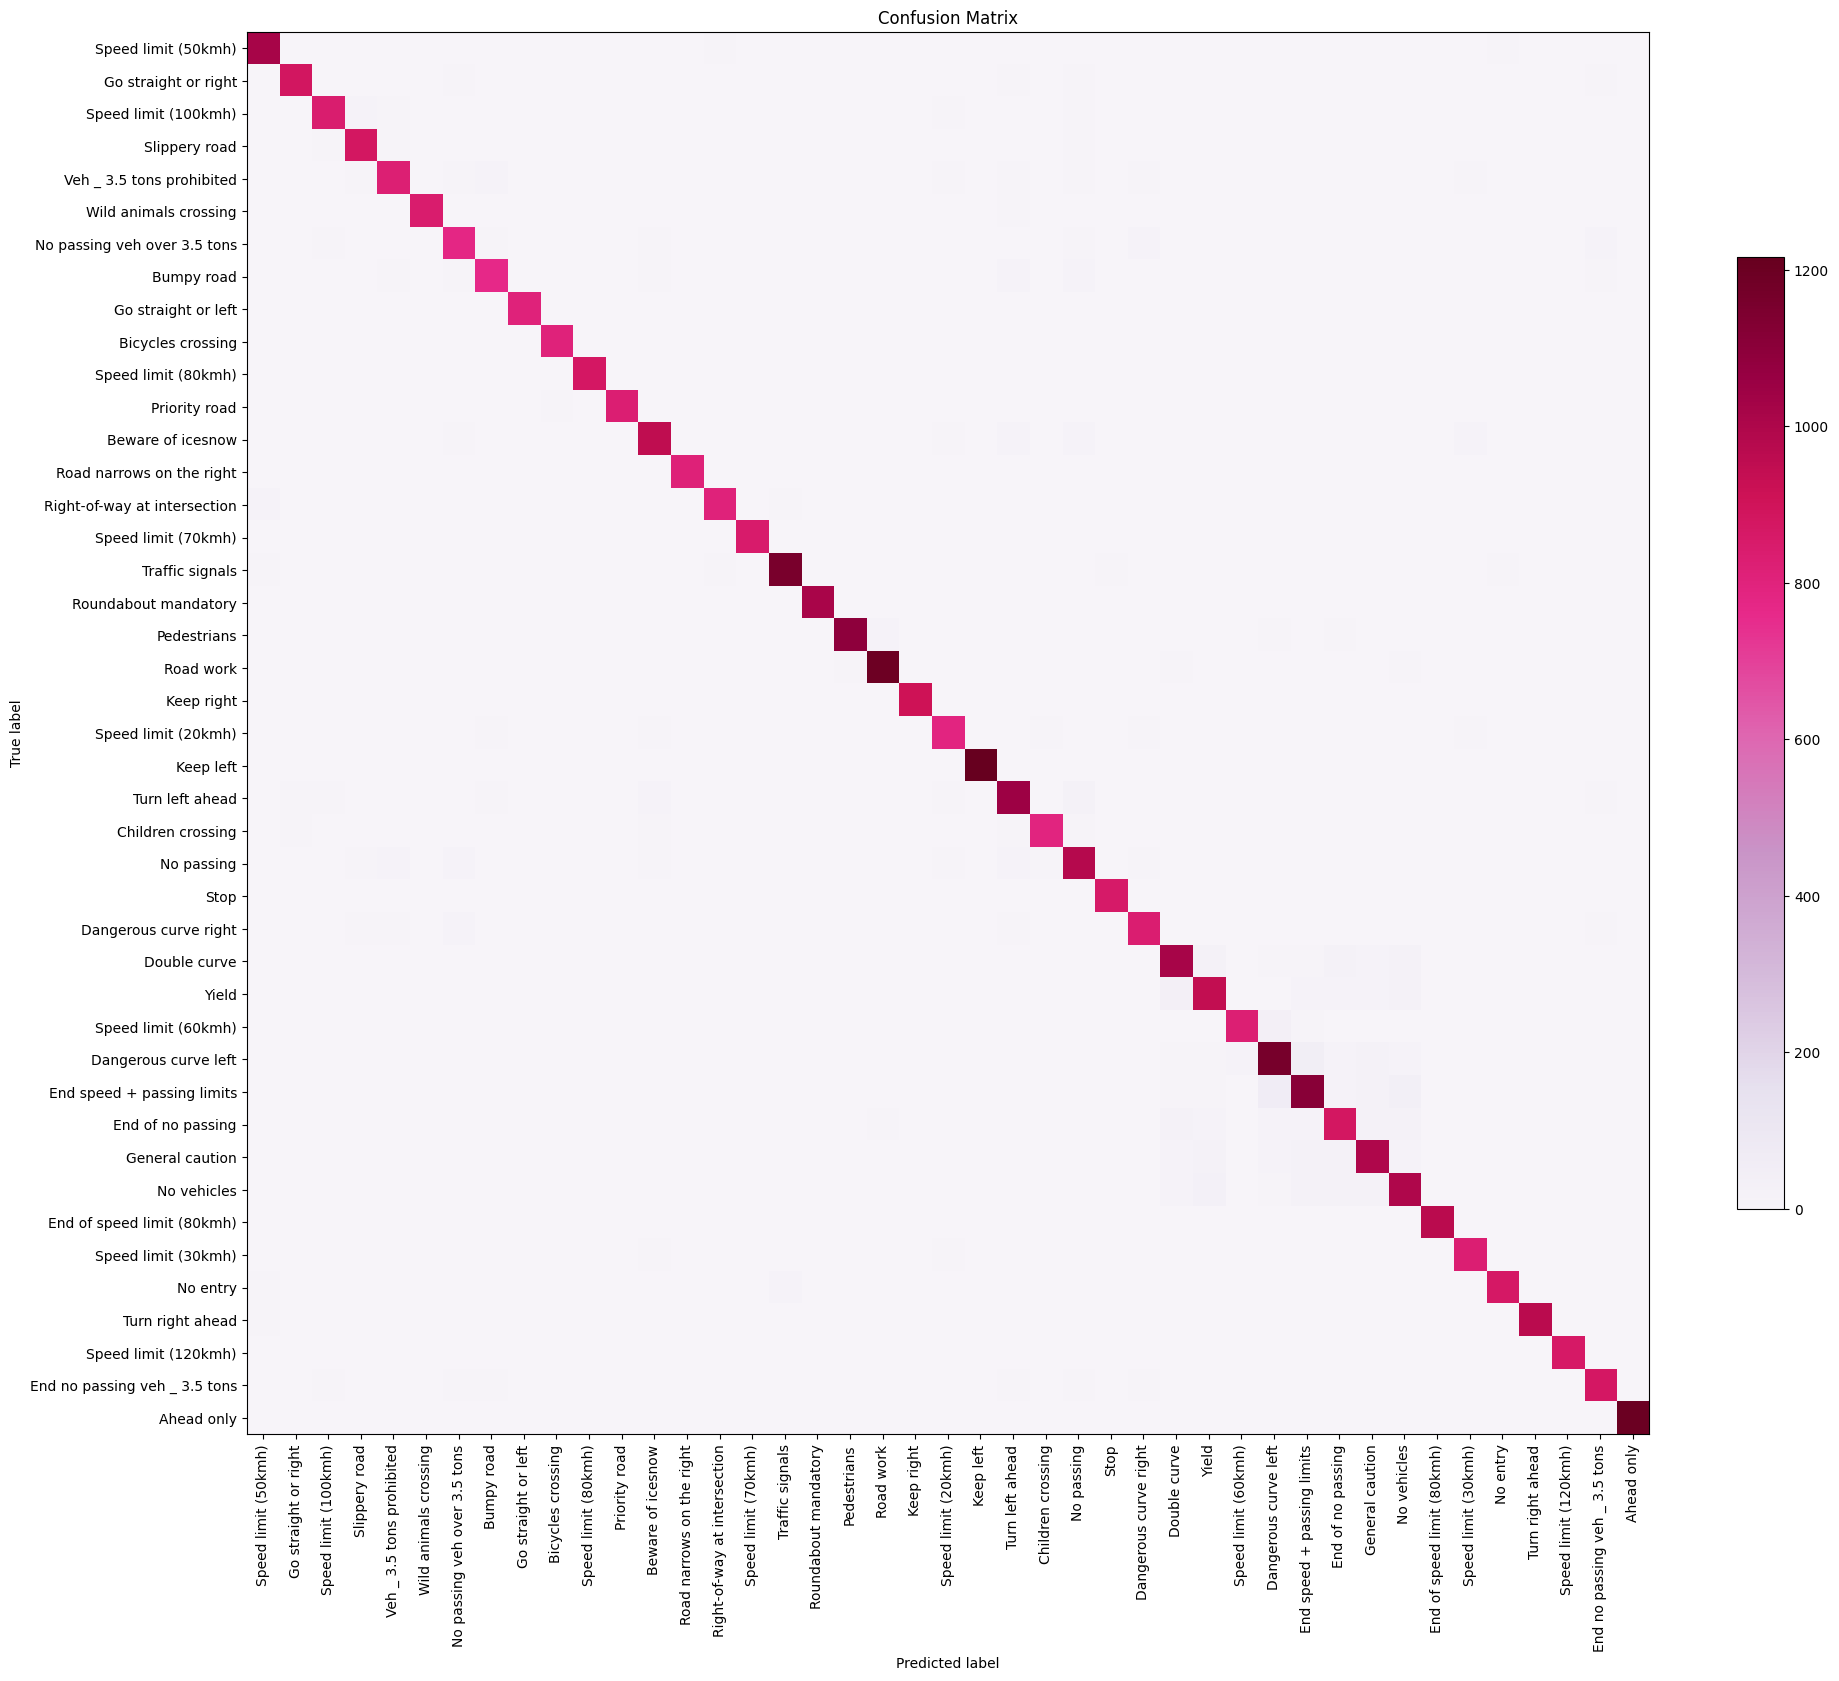

In [10]:
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred_classes = np.array([])
y_true = np.array([])
class_names = os.listdir('/kaggle/input/adversarial-gtsrb-data/Adversarial-GTSRB-Data/')

for x, y in val_data:
    y_pred_classes = np.concatenate([y_pred_classes, np.argmax(model.predict(x, verbose=0), axis=1)])
    y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])
    
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)
plt.title('Confusion Matrix')
plt.colorbar(shrink=0.5)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# # Plot the text on each cell
# thresh = cm_normalized.max() / 2.
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]): 
#         plt.text(j, i, format(cm[i, j], '.2f'),
#                  horizontalalignment="center",
#                  color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show('Predicted label')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

accuracy = (TP + TN) / (TP + TN + FP + FN)
error_rate = 1 - accuracy

error_rate_dict = {class_names[i]: error_rate[i]*100 for i in range(len(error_rate))}
df = pd.DataFrame(list(error_rate_dict.values()), columns=['Error Rate'])
df.index = error_rate_dict.keys()

df

,Error Rate
Speed limit (50kmh),0.165716
Go straight or right,0.208328
Speed limit (100kmh),0.229635
Slippery road,0.194124
Veh _ 3.5 tons prohibited,0.300656
Wild animals crossing,0.113634
No passing veh over 3.5 tons,0.397718
Bumpy road,0.343268
Go straight or left,0.101797
Bicycles crossing,0.061552


In [12]:
misclassification_rate = 1 - accuracy_score(y_pred_classes, y_true)

# Calculate Sensitivity (True Positive Rate / Recall)
sensitivity = TP / (TP + FN)

# Calculate Specificity
specificity = TN / (TN + FP)

print(f"\nMisclassification Rate: {misclassification_rate}")


Misclassification Rate: 0.05497028952913041


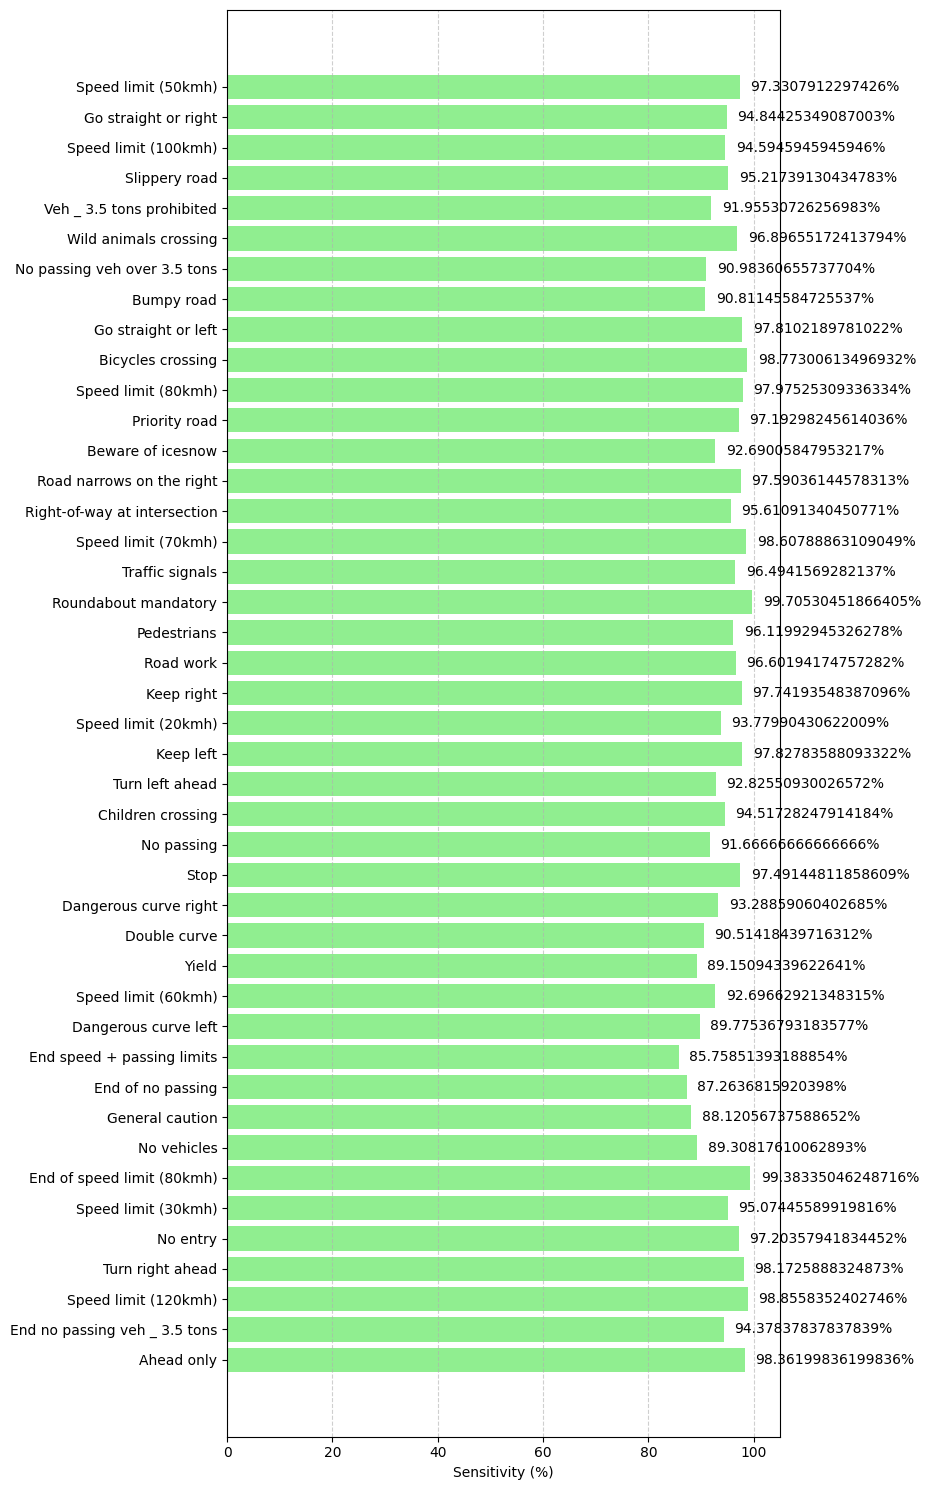

In [13]:
sensitivity = sensitivity*100

# Create a bar chart
plt.figure(figsize=(8, 15))
plt.barh(class_names, sensitivity, color='lightgreen')
plt.xlabel('Sensitivity (%)')
plt.gca().invert_yaxis()  # Reverse the order of classes for better readability
plt.xlim(0, 105)  # Adjust x-axis limits
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the sensitivities on top of the bars
for i, Sensitivity in enumerate(sensitivity):
    plt.text(Sensitivity + 2, i, f'{Sensitivity}%', va='center', fontsize=10)

plt.show()

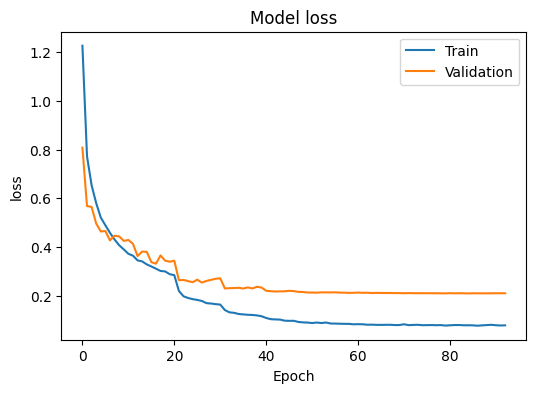

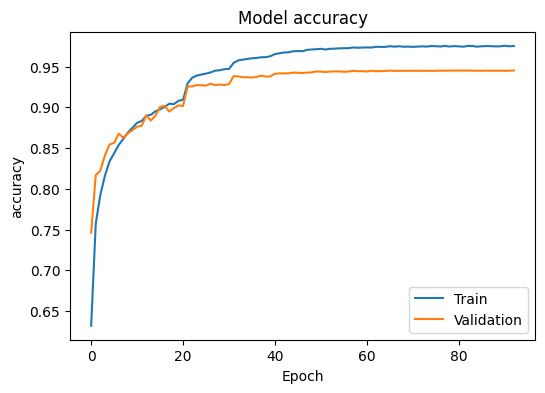

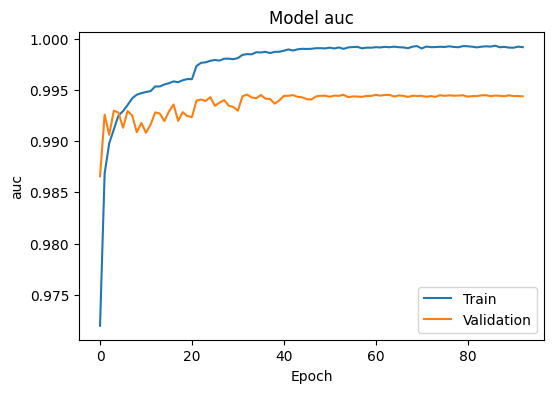

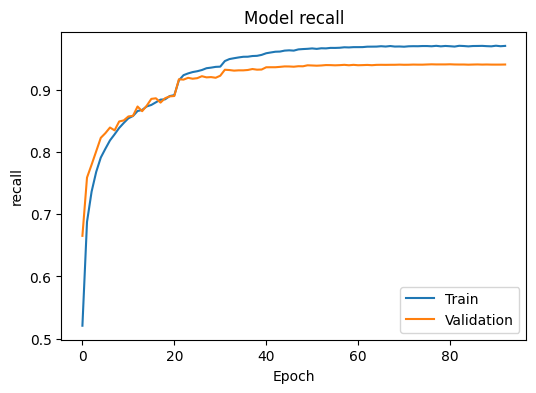

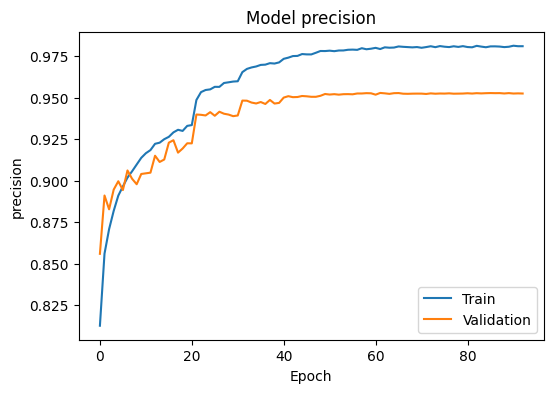

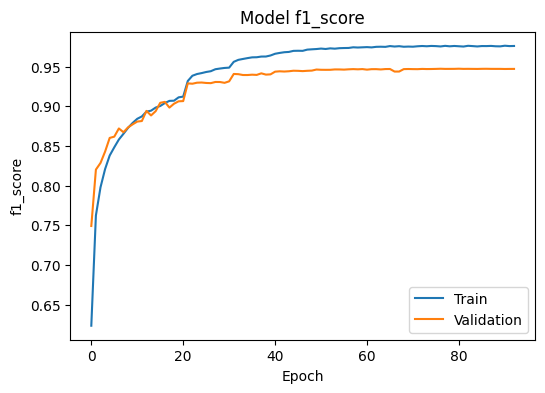

In [14]:
metrics = list(history.history.keys())

for metric in metrics:
    if metric.startswith('val')==False and metric!='lr':
        plt.figure(figsize=(6, 4))
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+metric])
        plt.title('Model '+metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        if metric.endswith('loss'):
            plt.legend(['Train', 'Validation'], loc='upper right')
        else:
            plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

331/331 [==============================] - 11s 26ms/step


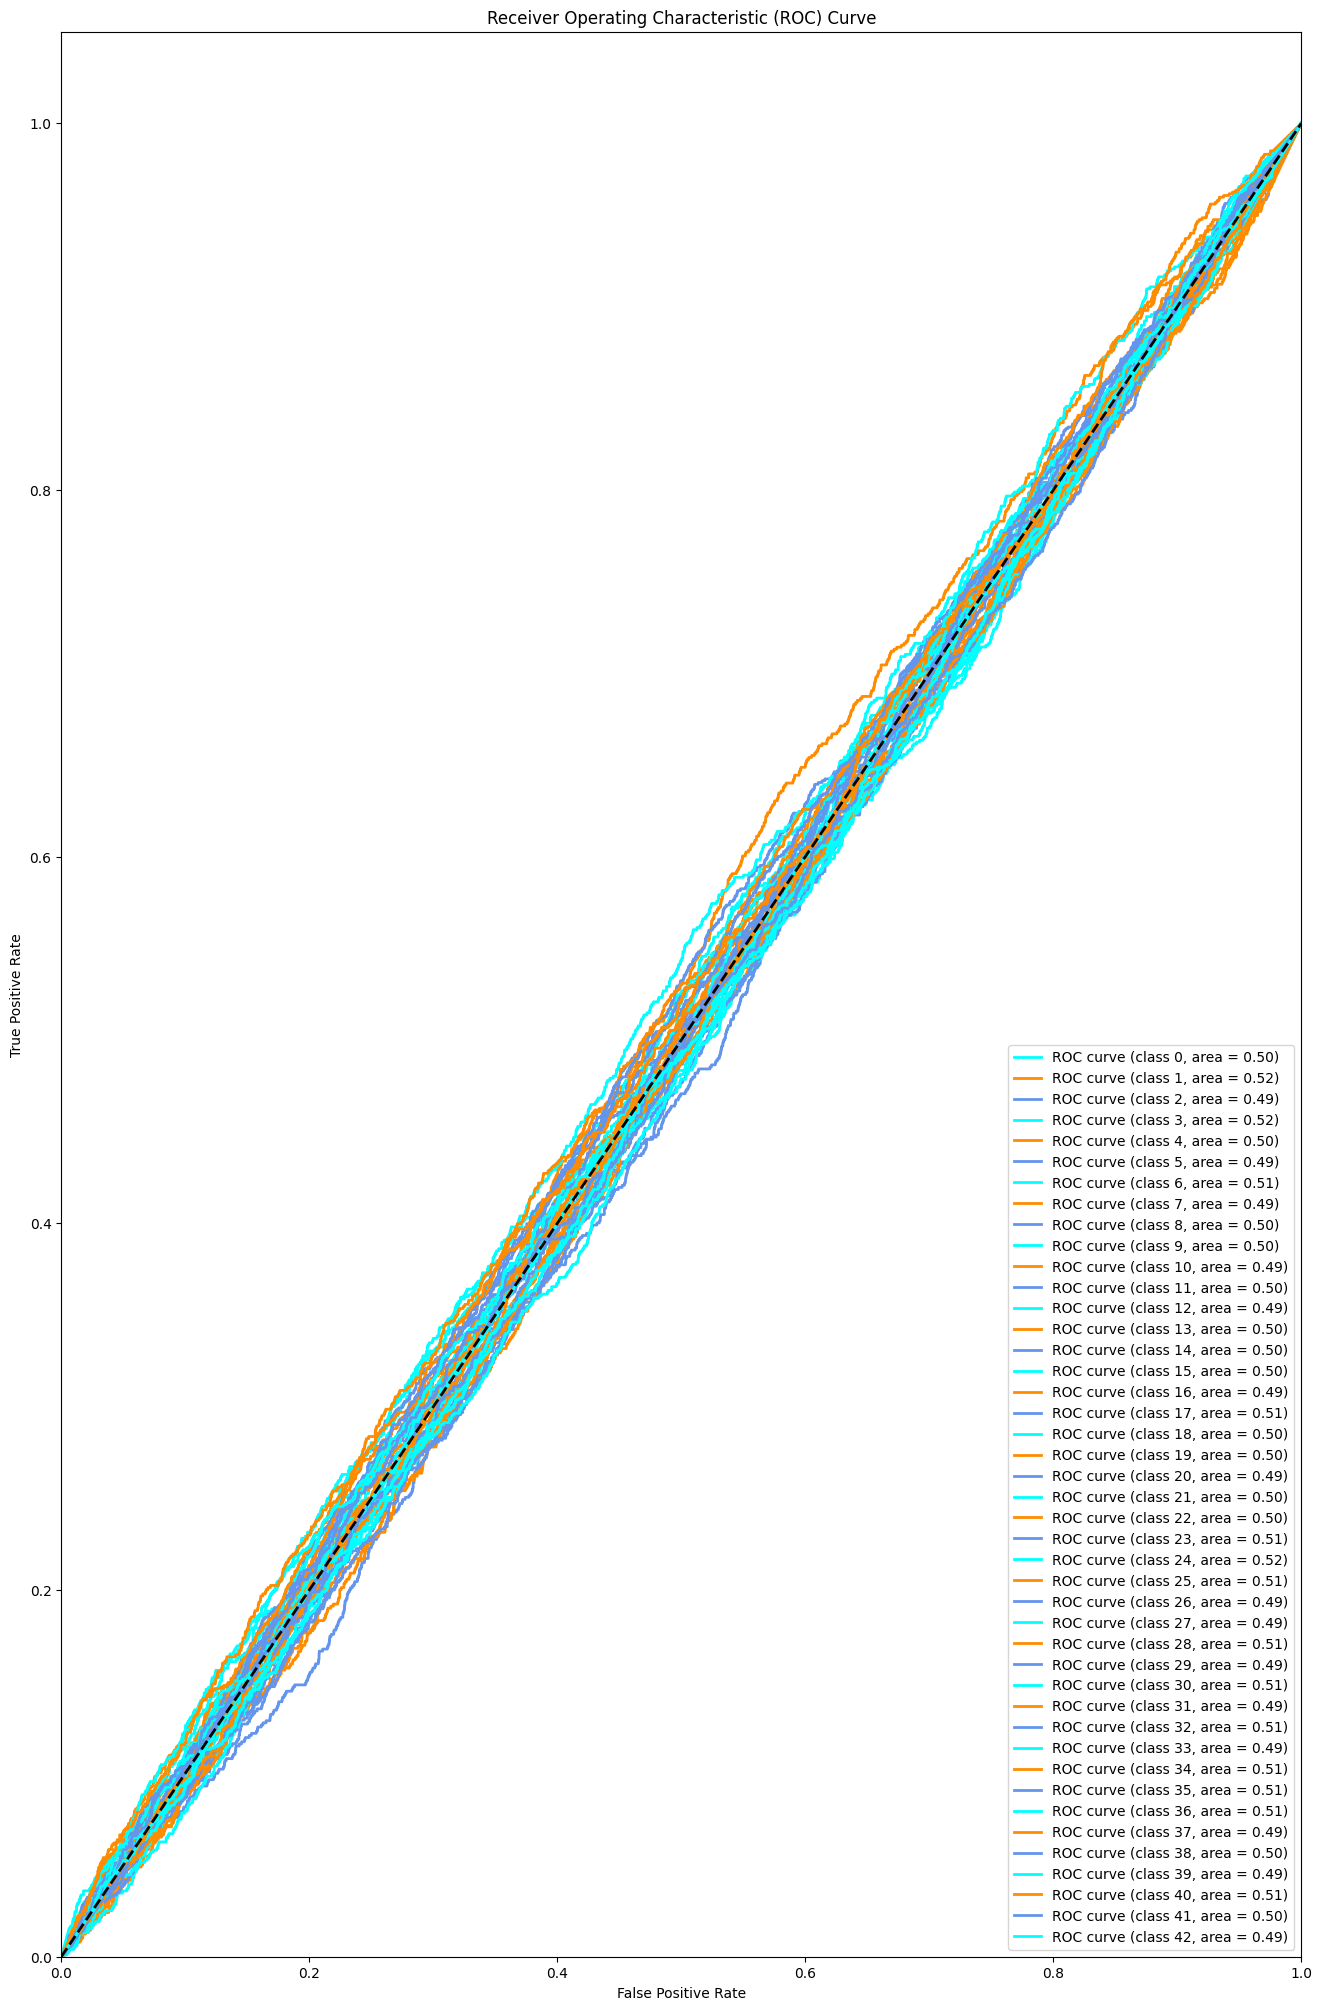

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_true_classes = y_true
num_classes = 43

# Plot ROC curve for each class (one-vs-all)
n_classes = num_classes
y_true_bin = label_binarize(y_true_classes, classes=np.arange(n_classes))
y_score = model.predict(val_data)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(16, 25))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()